In [1]:
import cPickle as pickle
%pylab inline

import scipy
import numpy as np
import pandas as pd
#import plotly.plotly as py
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
import re

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils
from keras.layers.convolutional import Convolution1D, MaxPooling1D, ZeroPadding1D, AveragePooling1D
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import sequence
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN, LSTM, GRU
from keras.layers.wrappers import TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.regularizers import l2, activity_l2
from keras.regularizers import l1, activity_l1
from keras.utils.visualize_util import plot

import pydot
import graphviz
from collections import Counter

import sklearn
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_score, recall_score,f1_score, accuracy_score
from sklearn.utils import shuffle
from sklearn.cross_validation import StratifiedKFold, train_test_split, cross_val_score

from imblearn.over_sampling import SMOTE


print ("Required Libraries loaded.")

Populating the interactive namespace from numpy and matplotlib


Using Theano backend.


Required Libraries loaded.


In [2]:
# Import the data and explore the first few rows
# Import the data and explore the first few rows

inhibitor  = pd.read_csv("C:/EPC_Data/TREC_BROKEN/No_Mh_Tag/aceinhibitor_no_mh.csv", sep=",")#, index_col='PMID')
header = inhibitor.columns.values
inhibitor.head()

,PMID,Label,TIABSMh
0,10099033,0,Effects of delapril in combination with indapa...
1,10099034,0,Clinical and neurohormonal effects of nicardip...
2,10099064,0,Effect of benazepril on endothelial function i...
3,10099075,0,Lowdose combination treatment for hypertension...
4,10130617,0,Development implementation and results of a su...


In [3]:
data = shuffle(inhibitor, random_state = 57)
data.head()

,PMID,Label,TIABSMh
873,7589767,0,Antihypertensive efficacy and safe use of once...
411,11281234,0,Comparison of two calcium blockers on hemodyna...
2145,9243145,0,More favourable haemodynamic effects from meto...
2061,9088591,0,The effect of the neutral endopeptidase inhibi...
118,10740141,0,Randomized trial of candesartan cilexetil in t...


In [4]:
#separate positive and negative data
#separate to negative and positive samples
# Select all rows with the index label "E"
negative_samples = inhibitor[inhibitor.Label == 0]#[lambda df: df.Label=='E', :]
positive_samples = inhibitor[inhibitor.Label == 1]#inhibitor.loc[lambda df: df.Label == 'I', :]

print ("Before resampling:")
print ("Whole dataset: ", inhibitor.shape)
print ("Positive sample: ", positive_samples.shape)
print ("Negative samples: ", negative_samples.shape)

#divide to training and test sets
hold_neg = negative_samples.sample(n=8, random_state=2)
rem_neg = negative_samples.drop(hold_neg.index)

hold_pos = positive_samples.sample(n=5, random_state=2)
rem_pos = positive_samples.drop(hold_pos.index)

#hold_label = ([1] * hold_pos.shape[0] + [0] * hold_neg.shape[0])


print (hold_neg.shape)
print (rem_neg.shape)
print (hold_pos.shape)
print (rem_pos.shape)

all_hold =[hold_neg, hold_pos]
hold = pd.concat(all_hold)

all_rem = [rem_neg, rem_pos]
rem = pd.concat(all_rem)

print (hold.shape)
print (rem.shape)

Before resampling:
('Whole dataset: ', (2498, 3))
('Positive sample: ', (39, 3))
('Negative samples: ', (2459, 3))
(8, 3)
(2451, 3)
(5, 3)
(34, 3)
(13, 3)
(2485, 3)


,PMID,Label,TIABSMh
974,7752178,0,Different longterm metabolic effects of enalap...
998,7786697,0,Early intravenous magnesium administration in ...
2041,9050976,0,Placebocontrolled comparison of the efficacy a...
735,11990112,0,Enalapril in the treatment of chronic mountain...
1499,10520779,0,Angiotensinconverting enzyme inhibition reduce...


In [5]:
# Import articles for string cleaning
sample_len = dataset.size
def clean_text(text, stem_words = False, remove_stopwords = True):
    ###clean
    texts = re.sub("[^a-zA-Z]",    #pattern to match
              " ",              #replace other with this
              str(text))                 #text to apply to
              
    clean_corpus = texts.lower().split()
    if stem_words:
        # Porter stemmer
        porter = nltk.PorterStemmer()
        # Snowball stemmer
        snowball = nltk.SnowballStemmer('english')
        # Lancaster stemmer
        lancaster = nltk.LancasterStemmer()
        # General stemming Lambda function to stem tokens
        clean_corpus = lambda tokens: [porter.stem(w) for w in corpus]
    if remove_stopwords:   # Optionally remove stop words
        stops = set(stopwords.words("english"))
        clean_corpus = [w for w in clean_corpus if not w in stops]#
    
    return (" ".join(clean_corpus))

In [6]:
print ("Cleaning and parsing the document...\n")

cleaned_corpus = []

count = 0
for i in dataset.index:
    if ((count+1)%1000 == 0):
        print ("Processing %d of %d \n" %(count+1, sample_len))
        
    cleaned_corpus.append(clean_text(dataset.iloc[i], stem_words = False, remove_stopwords = True))
    count +=1
print ("Finished data loading and cleaning")

Cleaning and parsing the document...

Processing 200 of 2498 

Processing 400 of 2498 

Processing 600 of 2498 

Processing 800 of 2498 

Processing 1000 of 2498 

Processing 1200 of 2498 

Processing 1400 of 2498 

Processing 1600 of 2498 

Processing 1800 of 2498 

Processing 2000 of 2498 

Processing 2200 of 2498 

Processing 2400 of 2498 

Finished data loading and cleaning


In [7]:
#decide on the total number of terms to retain
num_words = 10000
tok = Tokenizer(num_words)
size = data.shape[0] 
print ("fitting ...")
tok.fit_on_texts(cleaned_corpus[:size])  #0 to 25000

print ("fitted to training data")

fitting ...
fitted to training data


In [8]:
words = []
for iter in range(num_words):
    words += [key for key,value in tok.word_index.items() if value==iter+1]

print "done"

done


In [9]:
words[:10]

['patients',
 'use',
 'effects',
 'blood',
 'treatment',
 'p',
 'aged',
 'pressure',
 'study',
 'enzyme']

In [10]:
#use the tokenizer to construct data matricies that look like the ones pre-supplied by keras
X = tok.texts_to_sequences(cleaned_corpus[:size])

X = sequence.pad_sequences(X, maxlen=100)

y = data.Label

print "done"

done


In [11]:
##extract startified hold out set from the data before SMOTING
X_all, X_hold, y_all, y_hold = train_test_split(X, y, random_state = 5, stratify = y, test_size = 0.2)

#subdivide the X_all to remove validation set before SMOTing
X, X_test, y, y_test = train_test_split(X_all, y_all, random_state = 5, stratify = y_all, test_size = 0.25)

In [ ]:
# perform smote
sm = SMOTE(ratio = 'auto', kind = 'regular', random_state=55)

X_train, y_train = sm.fit_sample(X, y)
print('Resampled dataset shape {}'.format(Counter(y_train)))

#X_train, X_test, y_train, y_test = train_test_split(X_data, y_label, random_state = 55)

#create another data set with ratio option
sm = SMOTE(ratio = 0.5, kind = 'regular', random_state=55)

X_train_os, y_train_os = sm.fit_sample(X, y)
print('Resampled dataset shape {}'.format(Counter(y_train_os)))

#X_train_os, X_test_os, y_train_os, y_test_os = train_test_split(X_data_os, y_label_os, random_state = 55)

In [15]:
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
y_train_os = np.asarray(y_train_os)
y_test_os = np.asarray(y_test)
y_hold = np.asarray(y_hold)

#### build models

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_4 (Embedding)          (None, 100, 32)       320000      embedding_input_4[0][0]          
____________________________________________________________________________________________________
dropout_7 (Dropout)              (None, 100, 32)       0           embedding_4[0][0]                
____________________________________________________________________________________________________
simplernn_4 (SimpleRNN)          (None, 16)            784         dropout_7[0][0]                  
____________________________________________________________________________________________________
dense_7 (Dense)                  (None, 256)           4352        simplernn_4[0][0]                
___________________________________________________________________________________________

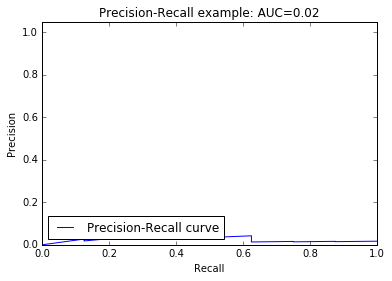

In [28]:
#1. Basic RNN
rnn1_model = Sequential()

rnn1_model.add(Embedding(num_words, 32, input_length=100))
rnn1_model.add(Dropout(0.25))

rnn1_model.add(SimpleRNN(16, return_sequences=False))

rnn1_model.add(Dense(256, W_regularizer=l2(0.01), activity_regularizer=activity_l2(0.01)))
rnn1_model.add(Dropout(0.25))
rnn1_model.add(Activation('relu'))

rnn1_model.add(Dense(1))
rnn1_model.add(Activation('sigmoid'))

rnn1_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print rnn1_model.summary()
####################################################

rnn1_model.fit(X_train, y_train, batch_size=32, nb_epoch=3, verbose=1,validation_data=(X_test, y_test))
score = rnn1_model.evaluate(X_test, y_test, batch_size=32, verbose=0, show_accuracy=True)
print('Test score:', score[0])
print('Test accuracy:', score[1])

y_score = rnn1_model.predict(X_test, batch_size=32)
#########################################################
print("classification report for RNN 'auto' SMOTE Oversampling dataset:")
auc_score = metrics.roc_auc_score(y_test, y_score)
print("*** AUC for ROC = %0.3f\n" % auc_score)

rnn1_pred = rnn1_model.predict_classes(X_test)

accuracy = accuracy_score(y_test, rnn1_pred)
recall = recall_score(y_test, rnn1_pred)
precision = precision_score(y_test, rnn1_pred)
f1 = f1_score(y_test, rnn1_pred)

print('\nAccuracy: {}'.format(accuracy))
print('Recall: {}'.format(recall))
print('Precision: {}'.format(precision))
print('F1: {}'.format(f1))

categories = ['Irrelevant', 'Relevant']
print("classification report:")
print(metrics.classification_report(y_test, rnn1_pred,target_names=categories))

print("confusion matrix:")
print(metrics.confusion_matrix(y_test, rnn1_pred))

###################################################
precision, recall, threshold = metrics.precision_recall_curve(y_test, y_score)
average_precision = metrics.average_precision_score(y_test, y_score)

plt.clf()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")

In [29]:
X_hold.shape

(500L, 100L)

classification report for RNN 'auto' SMOTE Oversampling dataset:
*** AUC for ROC = 0.756

448/500 [=========================>....] - ETA: 0s
Accuracy: 0.974
Recall: 0.125
Precision: 0.142857142857
F1: 0.133333333333
classification report:
             precision    recall  f1-score   support

 Irrelevant       0.99      0.99      0.99       492
   Relevant       0.14      0.12      0.13         8

avg / total       0.97      0.97      0.97       500

confusion matrix:
[[486   6]
 [  7   1]]


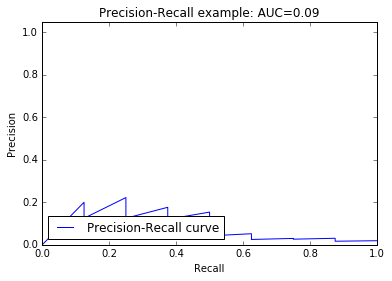

In [30]:
y_score = rnn1_model.predict(X_hold, batch_size=32)

#########################################################
print("classification report for RNN 'auto' SMOTE Oversampling dataset:")
auc_score = metrics.roc_auc_score(y_hold, y_score)
print("*** AUC for ROC = %0.3f\n" % auc_score)

rnn1_pred = rnn1_model.predict_classes(X_hold)


accuracy = accuracy_score(y_hold, rnn1_pred)
recall = recall_score(y_hold, rnn1_pred)
precision = precision_score(y_hold, rnn1_pred)
f1 = f1_score(y_hold, rnn1_pred)

print('\nAccuracy: {}'.format(accuracy))
print('Recall: {}'.format(recall))
print('Precision: {}'.format(precision))
print('F1: {}'.format(f1))

categories = ['Irrelevant', 'Relevant']
print("classification report:")
print(metrics.classification_report(y_hold, rnn1_pred,target_names=categories))

print("confusion matrix:")
print(metrics.confusion_matrix(y_hold, rnn1_pred))

###################################################
precision, recall, threshold = metrics.precision_recall_curve(y_hold, y_score)
average_precision = metrics.average_precision_score(y_hold, y_score)

plt.clf()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_5 (Embedding)          (None, 100, 32)       320000      embedding_input_5[0][0]          
____________________________________________________________________________________________________
dropout_9 (Dropout)              (None, 100, 32)       0           embedding_5[0][0]                
____________________________________________________________________________________________________
simplernn_5 (SimpleRNN)          (None, 16)            784         dropout_9[0][0]                  
____________________________________________________________________________________________________
dense_9 (Dense)                  (None, 256)           4352        simplernn_5[0][0]                
___________________________________________________________________________________________

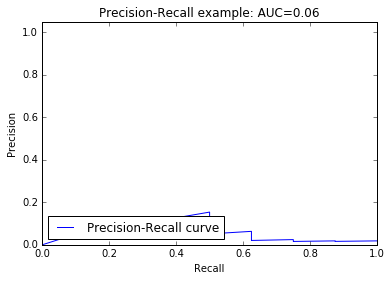

In [31]:
#1. Basic RNN
rnn2_model = Sequential()

rnn2_model.add(Embedding(num_words, 32, input_length=100))
rnn2_model.add(Dropout(0.25))

rnn2_model.add(SimpleRNN(16, return_sequences=False))

rnn2_model.add(Dense(256, W_regularizer=l2(0.01), activity_regularizer=activity_l2(0.01)))
rnn2_model.add(Dropout(0.25))
rnn2_model.add(Activation('relu'))

rnn2_model.add(Dense(1))
rnn2_model.add(Activation('sigmoid'))

rnn2_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print rnn2_model.summary()
####################################################

rnn2_model.fit(X_train_os, y_train_os, batch_size=32, nb_epoch=5, verbose=1,validation_data=(X_test, y_test))
score = rnn2_model.evaluate(X_test, y_test, batch_size=32, verbose=0, show_accuracy=True)
print('Test score:', score[0])
print('Test accuracy:', score[1])

y_score = rnn2_model.predict(X_test, batch_size=32)
#########################################################
print("classification report for RNN 0.5 SMOTE Oversampling dataset:")
auc_score = metrics.roc_auc_score(y_test, y_score)
print("*** AUC for ROC = %0.3f\n" % auc_score)

rnn2_pred = rnn2_model.predict_classes(X_test)

accuracy = accuracy_score(y_test, rnn2_pred)
recall = recall_score(y_test, rnn2_pred)
precision = precision_score(y_test, rnn2_pred)
f1 = f1_score(y_test, rnn2_pred)

print('\nAccuracy: {}'.format(accuracy))
print('Recall: {}'.format(recall))
print('Precision: {}'.format(precision))
print('F1: {}'.format(f1))


print(metrics.classification_report(y_test, rnn2_pred,target_names=categories))

print("confusion matrix:")
print(metrics.confusion_matrix(y_test, rnn2_pred))

###################################################
precision, recall, threshold = metrics.precision_recall_curve(y_test, y_score)
average_precision = metrics.average_precision_score(y_test, y_score)

plt.clf()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")

classification report for RNN 0.5 SMOTE Oversampling dataset:
*** AUC for ROC = 0.858

448/500 [=========================>....] - ETA: 0s
Accuracy: 0.976
Recall: 0.125
Precision: 0.166666666667
F1: 0.142857142857
             precision    recall  f1-score   support

 Irrelevant       0.99      0.99      0.99       492
   Relevant       0.17      0.12      0.14         8

avg / total       0.97      0.98      0.97       500

confusion matrix:
[[487   5]
 [  7   1]]


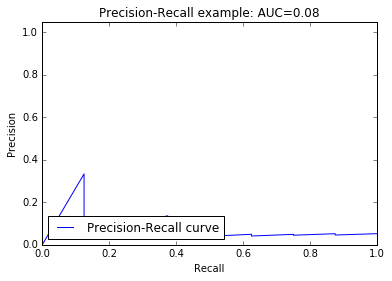

In [32]:
y_score = rnn2_model.predict(X_hold, batch_size=32)
#########################################################
print("classification report for RNN 0.5 SMOTE Oversampling dataset:")
auc_score = metrics.roc_auc_score(y_hold, y_score)
print("*** AUC for ROC = %0.3f\n" % auc_score)

rnn2_pred = rnn2_model.predict_classes(X_hold)

accuracy = accuracy_score(y_hold, rnn2_pred)
recall = recall_score(y_hold, rnn2_pred)
precision = precision_score(y_hold, rnn2_pred)
f1 = f1_score(y_hold, rnn2_pred)

print('\nAccuracy: {}'.format(accuracy))
print('Recall: {}'.format(recall))
print('Precision: {}'.format(precision))
print('F1: {}'.format(f1))


print(metrics.classification_report(y_hold, rnn2_pred,target_names=categories))

print("confusion matrix:")
print(metrics.confusion_matrix(y_hold, rnn2_pred))

###################################################
precision, recall, threshold = metrics.precision_recall_curve(y_hold, y_score)
average_precision = metrics.average_precision_score(y_hold, y_score)

plt.clf()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")

RNN 256
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_8 (Embedding)          (None, 100, 32)       320000      embedding_input_8[0][0]          
____________________________________________________________________________________________________
dropout_15 (Dropout)             (None, 100, 32)       0           embedding_8[0][0]                
____________________________________________________________________________________________________
simplernn_8 (SimpleRNN)          (None, 16)            784         dropout_15[0][0]                 
____________________________________________________________________________________________________
dense_15 (Dense)                 (None, 256)           4352        simplernn_8[0][0]                
___________________________________________________________________________________

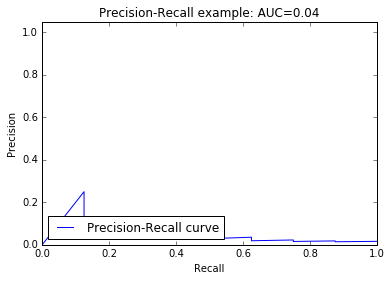

In [35]:
print ("RNN 256")
rnn3_model = Sequential()

rnn3_model.add(Embedding(num_words, 32, input_length=100))
rnn3_model.add(Dropout(0.25))

rnn3_model.add(SimpleRNN(16, return_sequences=False))

rnn3_model.add(Dense(256, W_regularizer=l2(0.01), activity_regularizer=activity_l2(0.01)))
rnn3_model.add(Dropout(0.25))
rnn3_model.add(Activation('tanh'))

rnn3_model.add(Dense(1))
rnn3_model.add(Activation('sigmoid'))

rnn3_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print rnn3_model.summary()
#plot(model, to_file='model.png')
#model.get_config()

rnn3_model.fit(X_train, y_train, batch_size=32, nb_epoch=6, verbose=1,validation_data=(X_test, y_test))
score = rnn3_model.evaluate(X_test, y_test, batch_size=32, verbose=0, show_accuracy=True)
print('Test score:', score[0])
print('Test accuracy:', score[1])

y_score = rnn3_model.predict(X_test, batch_size=32)
#########################################################
print("classification report for RNN 'auto' SMOTE Oversampling dataset:")
auc_score = metrics.roc_auc_score(y_test, y_score)
print("*** AUC for ROC = %0.3f\n" % auc_score)

rnn3_pred = rnn3_model.predict_classes(X_test)

accuracy = accuracy_score(y_test, rnn3_pred)
recall = recall_score(y_test, rnn3_pred)
precision = precision_score(y_test, rnn3_pred)
f1 = f1_score(y_test, rnn3_pred)

print('\nAccuracy: {}'.format(accuracy))
print('Recall: {}'.format(recall))
print('Precision: {}'.format(precision))
print('F1: {}'.format(f1))

categories = ['Irrelevant', 'Relevant']
print("classification report:")
print(metrics.classification_report(y_test, rnn3_pred,target_names=categories))

print("confusion matrix:")
print(metrics.confusion_matrix(y_test, rnn3_pred))

###################################################
precision, recall, threshold = metrics.precision_recall_curve(y_test, y_score)
average_precision = metrics.average_precision_score(y_test, y_score)

plt.clf()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")

classification report for RNN 0.5 SMOTE Oversampling dataset:
*** AUC for ROC = 0.696

448/500 [=========================>....] - ETA: 0s
Accuracy: 0.97
Recall: 0.25
Precision: 0.181818181818
F1: 0.210526315789
             precision    recall  f1-score   support

 Irrelevant       0.99      0.98      0.98       492
   Relevant       0.18      0.25      0.21         8

avg / total       0.97      0.97      0.97       500

confusion matrix:
[[483   9]
 [  6   2]]


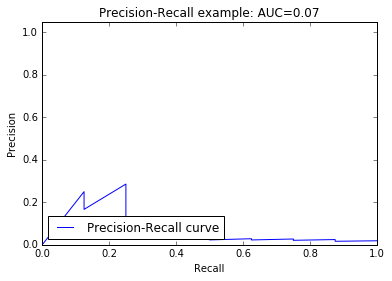

In [36]:
y_score = rnn3_model.predict(X_hold, batch_size=32)
#########################################################
print("classification report for RNN 0.5 SMOTE Oversampling dataset:")
auc_score = metrics.roc_auc_score(y_hold, y_score)
print("*** AUC for ROC = %0.3f\n" % auc_score)

rnn3_pred = rnn3_model.predict_classes(X_hold)

accuracy = accuracy_score(y_hold, rnn3_pred)
recall = recall_score(y_hold, rnn3_pred)
precision = precision_score(y_hold, rnn3_pred)
f1 = f1_score(y_hold, rnn3_pred)

print('\nAccuracy: {}'.format(accuracy))
print('Recall: {}'.format(recall))
print('Precision: {}'.format(precision))
print('F1: {}'.format(f1))


print(metrics.classification_report(y_hold, rnn3_pred,target_names=categories))

print("confusion matrix:")
print(metrics.confusion_matrix(y_hold, rnn3_pred))

###################################################
precision, recall, threshold = metrics.precision_recall_curve(y_hold, y_score)
average_precision = metrics.average_precision_score(y_hold, y_score)

plt.clf()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")

RNN 256
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_11 (Embedding)         (None, 100, 32)       320000      embedding_input_11[0][0]         
____________________________________________________________________________________________________
dropout_21 (Dropout)             (None, 100, 32)       0           embedding_11[0][0]               
____________________________________________________________________________________________________
simplernn_11 (SimpleRNN)         (None, 8)             328         dropout_21[0][0]                 
____________________________________________________________________________________________________
dense_21 (Dense)                 (None, 256)           2304        simplernn_11[0][0]               
___________________________________________________________________________________

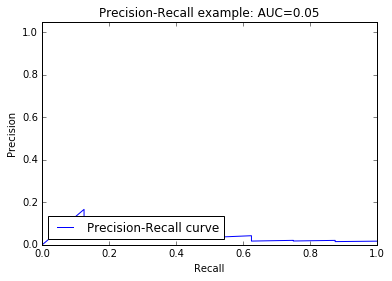

In [41]:
print ("RNN 256")
rnn4_model = Sequential()

rnn4_model.add(Embedding(num_words, 32, input_length=100))
rnn4_model.add(Dropout(0.25))

rnn4_model.add(SimpleRNN(8, return_sequences=False))

rnn4_model.add(Dense(256, W_regularizer=l2(0.01), activity_regularizer=activity_l2(0.01)))
rnn4_model.add(Dropout(0.25))
rnn4_model.add(Activation('tanh'))

rnn4_model.add(Dense(1))
rnn4_model.add(Activation('sigmoid'))

rnn4_model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=['accuracy'])
print rnn4_model.summary()
#plot(model, to_file='model.png')
#model.get_config()

rnn4_model.fit(X_train_os, y_train_os, batch_size=32, nb_epoch=2, verbose=0,validation_data=(X_test, y_test))
score = rnn4_model.evaluate(X_test, y_test, batch_size=32, verbose=0, show_accuracy=True)
print('Test score:', score[0])
print('Test accuracy:', score[1])

y_score = rnn4_model.predict(X_test, batch_size=32)
#########################################################
print("classification report for RNN 'auto' SMOTE Oversampling dataset:")
auc_score = metrics.roc_auc_score(y_test, y_score)
print("*** AUC for ROC = %0.3f\n" % auc_score)

rnn4_pred = rnn4_model.predict_classes(X_test)

accuracy = accuracy_score(y_test, rnn4_pred)
recall = recall_score(y_test, rnn4_pred)
precision = precision_score(y_test, rnn4_pred)
f1 = f1_score(y_test, rnn4_pred)

print('\nAccuracy: {}'.format(accuracy))
print('Recall: {}'.format(recall))
print('Precision: {}'.format(precision))
print('F1: {}'.format(f1))


print("classification report:")
print(metrics.classification_report(y_test, rnn4_pred,target_names=categories))

print("confusion matrix:")
print(metrics.confusion_matrix(y_test, rnn4_pred))

###################################################
precision, recall, threshold = metrics.precision_recall_curve(y_test, y_score)
average_precision = metrics.average_precision_score(y_test, y_score)

plt.clf()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")

classification report for RNN 0.5 SMOTE Oversampling holdout dataset:
*** AUC for ROC = 0.832

448/500 [=========================>....] - ETA: 0s
Accuracy: 0.978
Recall: 0.125
Precision: 0.2
F1: 0.153846153846
             precision    recall  f1-score   support

 Irrelevant       0.99      0.99      0.99       492
   Relevant       0.20      0.12      0.15         8

avg / total       0.97      0.98      0.98       500

confusion matrix:
[[488   4]
 [  7   1]]


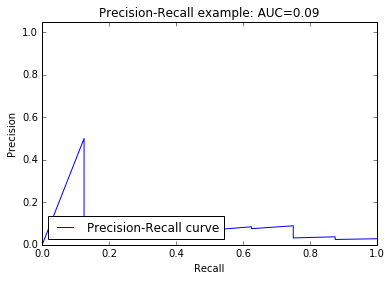

In [42]:
y_score = rnn4_model.predict(X_hold, batch_size=32)
#########################################################
print("classification report for RNN 0.5 SMOTE Oversampling holdout dataset:")
auc_score = metrics.roc_auc_score(y_hold, y_score)
print("*** AUC for ROC = %0.3f\n" % auc_score)

rnn4_pred = rnn4_model.predict_classes(X_hold)

accuracy = accuracy_score(y_hold, rnn4_pred)
recall = recall_score(y_hold, rnn4_pred)
precision = precision_score(y_hold, rnn4_pred)
f1 = f1_score(y_hold, rnn4_pred)

print('\nAccuracy: {}'.format(accuracy))
print('Recall: {}'.format(recall))
print('Precision: {}'.format(precision))
print('F1: {}'.format(f1))


print(metrics.classification_report(y_hold, rnn4_pred,target_names=categories))

print("confusion matrix:")
print(metrics.confusion_matrix(y_hold, rnn4_pred))

###################################################
precision, recall, threshold = metrics.precision_recall_curve(y_hold, y_score)
average_precision = metrics.average_precision_score(y_hold, y_score)

plt.clf()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")

(2950, 'train sequences')
(500, 'test sequences')
Pad sequences (samples x time)
('X_train shape:', (2950L, 100L))
('X_test shape:', (500L, 100L))
Build model...


C:\Users\CR107\Anaconda2\lib\site-packages\keras\models.py:336: UserWarning: "class_mode" argument is deprecated, please remove it.
  warnings.warn('"class_mode" argument is deprecated, '
C:\Users\CR107\Anaconda2\lib\site-packages\keras\models.py:396: UserWarning: The "show_accuracy" argument is deprecated, instead you should pass the "accuracy" metric to the model at compile time:
`model.compile(optimizer, loss, metrics=["accuracy"])`
  warnings.warn('The "show_accuracy" argument is deprecated, '


Train on 2950 samples, validate on 500 samples
Epoch 1/3
2950/2950 [==============================] - 5s - loss: 2.4644 - acc: 0.6278 - val_loss: 0.4376 - val_acc: 0.9760
Epoch 2/3
2950/2950 [==============================] - 5s - loss: 0.6379 - acc: 0.9593 - val_loss: 0.6249 - val_acc: 0.6660
Epoch 3/3
500/500 [==============================] - 0s     
Test score: 0.267
Test accuracy: 0.90
*** AUC for ROC = 0.670

500/500 [==============================] - 0s     

Accuracy: 0.902
Recall: 0.125
Precision: 0.0232558139535
F1: 0.0392156862745
classification report:
             precision    recall  f1-score   support

 Irrelevant       0.98      0.91      0.95       492
   Relevant       0.02      0.12      0.04         8

avg / total       0.97      0.90      0.93       500

confusion matrix:
[[450  42]
 [  7   1]]


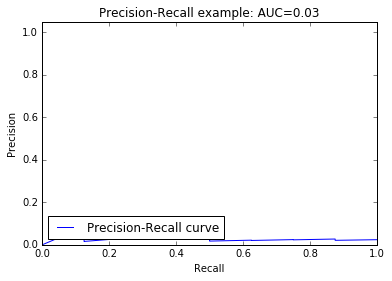

In [43]:
'''
    This example demonstrates the use of Convolution1D
    for text classification.
    Based on the examples from the Keras website  http://keras.io/
'''

# set parameters:
MAX_FEATURES= num_words
MAX_LEN = 100

batch_size = 128
embedding_dims = 16
nb_filter = 32
filter_length = 3
hidden_dims = 250
nb_epoch = 3

print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print("Pad sequences (samples x time)")
X_train = sequence.pad_sequences(X_train, maxlen=MAX_LEN)
X_test = sequence.pad_sequences(X_test, maxlen=MAX_LEN)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

print('Build model...')
cnn1_model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
cnn1_model.add(Embedding(MAX_FEATURES, embedding_dims, input_length=MAX_LEN))
cnn1_model.add(Dropout(0.25))

# we add a Convolution1D, which will learn nb_filter
# word group filters of size filter_length:
cnn1_model.add(Convolution1D(nb_filter=nb_filter,
                        filter_length=filter_length,
                        border_mode="valid",
                        activation="relu",
                        subsample_length=1))
# we use standard max pooling (halving the output of the previous layer):
cnn1_model.add(MaxPooling1D(pool_length=2))

# We flatten the output of the conv layer, so that we can add a vanilla dense layer:
cnn1_model.add(Flatten())

# We add a vanilla hidden layer:
cnn1_model.add(Dense(hidden_dims, W_regularizer=l2(0.01), activity_regularizer=activity_l2(0.01)))
cnn1_model.add(Dropout(0.25))
cnn1_model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
cnn1_model.add(Dense(1))
cnn1_model.add(Activation('sigmoid'))

cnn1_model.compile(loss='binary_crossentropy', optimizer='rmsprop', class_mode="binary", metrics=["accuracy"])
cnn1_model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch, show_accuracy=True, validation_data=(X_test, y_test))#, 
          #sample_weight = sw, class_weight = {0:1., 1:25.})
score = cnn1_model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1, show_accuracy=True)
print('Test score: %.3f' %score[0])
print('Test accuracy: %.2f' % score[1])

y_score = cnn1_model.predict(X_test, batch_size=batch_size)
auc_score = metrics.roc_auc_score(y_test, y_score)
print("*** AUC for ROC = %0.3f\n" % auc_score)

cnn1_pred = cnn1_model.predict_classes(X_test)

accuracy = accuracy_score(y_test, cnn1_pred)
recall = recall_score(y_test, cnn1_pred)
precision = precision_score(y_test, cnn1_pred)
f1 = f1_score(y_test, cnn1_pred)

print('\nAccuracy: {}'.format(accuracy))
print('Recall: {}'.format(recall))
print('Precision: {}'.format(precision))
print('F1: {}'.format(f1))

print("classification report:")
print(metrics.classification_report(y_test, cnn1_pred,target_names=categories))

print("confusion matrix:")
print(metrics.confusion_matrix(y_test, cnn1_pred))

################################
# Plot Precision-Recall curve
precision, recall, threshold = metrics.precision_recall_curve(y_test, y_score)
average_precision = metrics.average_precision_score(y_test, y_score)

plt.clf()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")
#plt.show()

classification report for RNN 0.5 SMOTE Oversampling holdout dataset:
*** AUC for ROC = 0.725

500/500 [==============================] - 0s     

Accuracy: 0.93
Recall: 0.125
Precision: 0.0344827586207
F1: 0.0540540540541
             precision    recall  f1-score   support

 Irrelevant       0.99      0.94      0.96       492
   Relevant       0.03      0.12      0.05         8

avg / total       0.97      0.93      0.95       500

confusion matrix:
[[464  28]
 [  7   1]]


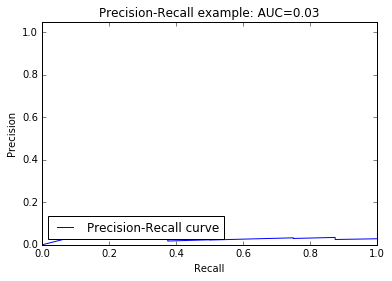

In [44]:
y_score = cnn1_model.predict(X_hold, batch_size=32)
#########################################################
print("classification report for RNN 0.5 SMOTE Oversampling holdout dataset:")
auc_score = metrics.roc_auc_score(y_hold, y_score)
print("*** AUC for ROC = %0.3f\n" % auc_score)

cnn1_pred = cnn1_model.predict_classes(X_hold)

accuracy = accuracy_score(y_hold, cnn1_pred)
recall = recall_score(y_hold, cnn1_pred)
precision = precision_score(y_hold, cnn1_pred)
f1 = f1_score(y_hold, cnn1_pred)

print('\nAccuracy: {}'.format(accuracy))
print('Recall: {}'.format(recall))
print('Precision: {}'.format(precision))
print('F1: {}'.format(f1))


print(metrics.classification_report(y_hold, cnn1_pred,target_names=categories))

print("confusion matrix:")
print(metrics.confusion_matrix(y_hold, cnn1_pred))

###################################################
precision, recall, threshold = metrics.precision_recall_curve(y_hold, y_score)
average_precision = metrics.average_precision_score(y_hold, y_score)

plt.clf()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")

(2212, 'train sequences')
(500, 'test sequences')
Pad sequences (samples x time)
('X_train shape:', (2212L, 100L))
('X_test shape:', (500L, 100L))
Build model...
Train on 2212 samples, validate on 500 samples
Epoch 1/3
2212/2212 [==============================] - 4s - loss: 2.7578 - acc: 0.6591 - val_loss: 0.3939 - val_acc: 0.9840
Epoch 2/3
2212/2212 [==============================] - 4s - loss: 0.9914 - acc: 0.8228 - val_loss: 0.1425 - val_acc: 0.9800
Epoch 3/3
500/500 [==============================] - 0s     
Test score: 0.110
Test accuracy: 0.98
*** AUC for ROC = 0.722

500/500 [==============================] - 0s     

Accuracy: 0.978
Recall: 0.0
Precision: 0.0
F1: 0.0
classification report:
             precision    recall  f1-score   support

 Irrelevant       0.98      0.99      0.99       492
   Relevant       0.00      0.00      0.00         8

avg / total       0.97      0.98      0.97       500

confusion matrix:
[[489   3]
 [  8   0]]


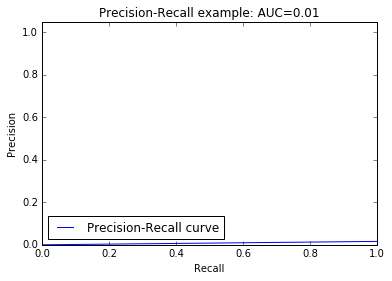

In [47]:
'''
    This example demonstrates the use of Convolution1D
    for text classification.
    Based on the examples from the Keras website  http://keras.io/
'''

# set parameters:
MAX_FEATURES= num_words
MAX_LEN = 100

batch_size = 128
embedding_dims = 16
nb_filter = 32
filter_length = 3
hidden_dims = 250
nb_epoch = 3

print(len(X_train_os), 'train sequences')
print(len(X_test), 'test sequences')

print("Pad sequences (samples x time)")
X_train_os = sequence.pad_sequences(X_train_os, maxlen=MAX_LEN)
X_test_os = sequence.pad_sequences(X_test, maxlen=MAX_LEN)
print('X_train shape:', X_train_os.shape)
print('X_test shape:', X_test.shape)

print('Build model...')
cnn2_model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
cnn2_model.add(Embedding(MAX_FEATURES, embedding_dims, input_length=MAX_LEN))
cnn2_model.add(Dropout(0.25))

# we add a Convolution1D, which will learn nb_filter
# word group filters of size filter_length:
cnn2_model.add(Convolution1D(nb_filter=nb_filter,
                        filter_length=filter_length,
                        border_mode="valid",
                        activation="relu",
                        subsample_length=1))
# we use standard max pooling (halving the output of the previous layer):
cnn2_model.add(MaxPooling1D(pool_length=2))

# We flatten the output of the conv layer, so that we can add a vanilla dense layer:
cnn2_model.add(Flatten())

# We add a vanilla hidden layer:
cnn2_model.add(Dense(hidden_dims, W_regularizer=l2(0.01), activity_regularizer=activity_l2(0.01)))
cnn2_model.add(Dropout(0.25))
cnn2_model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
cnn2_model.add(Dense(1))
cnn2_model.add(Activation('sigmoid'))

cnn2_model.compile(loss='binary_crossentropy', optimizer='rmsprop', class_mode="binary", metrics=["accuracy"])
cnn2_model.fit(X_train_os, y_train_os, batch_size=batch_size, nb_epoch=nb_epoch, show_accuracy=True, validation_data=(X_test, y_test))#, 
          #sample_weight = sw, class_weight = {0:1., 1:25.})
score = cnn2_model.evaluate(X_test_os, y_test_os, batch_size=batch_size, verbose=1, show_accuracy=True)
print('Test score: %.3f' %score[0])
print('Test accuracy: %.2f' % score[1])

y_score = cnn2_model.predict(X_test, batch_size=batch_size)
auc_score = metrics.roc_auc_score(y_test, y_score)
print("*** AUC for ROC = %0.3f\n" % auc_score)

cnn2_pred = cnn2_model.predict_classes(X_test)

accuracy = accuracy_score(y_test, cnn2_pred)
recall = recall_score(y_test, cnn2_pred)
precision = precision_score(y_test, cnn2_pred)
f1 = f1_score(y_test_os, cnn2_pred)

print('\nAccuracy: {}'.format(accuracy))
print('Recall: {}'.format(recall))
print('Precision: {}'.format(precision))
print('F1: {}'.format(f1))

print("classification report:")
print(metrics.classification_report(y_test, cnn2_pred,target_names=categories))

print("confusion matrix:")
print(metrics.confusion_matrix(y_test, cnn2_pred))

################################
# Plot Precision-Recall curve
precision, recall, threshold = metrics.precision_recall_curve(y_test, cnn2_pred)
average_precision = metrics.average_precision_score(y_test, cnn2_pred)

plt.clf()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")
#plt.show()

classification report for RNN 0.5 SMOTE Oversampling holdout dataset:
*** AUC for ROC = 0.738

416/500 [=======================>......] - ETA: 0s
Accuracy: 0.978
Recall: 0.125
Precision: 0.2
F1: 0.153846153846
             precision    recall  f1-score   support

 Irrelevant       0.99      0.99      0.99       492
   Relevant       0.20      0.12      0.15         8

avg / total       0.97      0.98      0.98       500

confusion matrix:
[[488   4]
 [  7   1]]


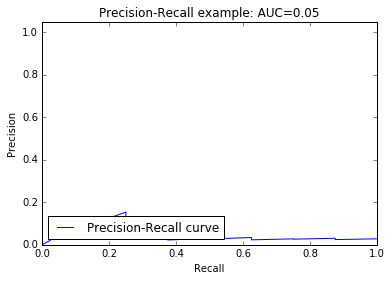

In [48]:
y_score = cnn2_model.predict(X_hold, batch_size=32)
#########################################################
print("classification report for RNN 0.5 SMOTE Oversampling holdout dataset:")
auc_score = metrics.roc_auc_score(y_hold, y_score)
print("*** AUC for ROC = %0.3f\n" % auc_score)

cnn2_pred = rnn4_model.predict_classes(X_hold)

accuracy = accuracy_score(y_hold, cnn2_pred)
recall = recall_score(y_hold, cnn2_pred)
precision = precision_score(y_hold, cnn2_pred)
f1 = f1_score(y_hold, cnn2_pred)

print('\nAccuracy: {}'.format(accuracy))
print('Recall: {}'.format(recall))
print('Precision: {}'.format(precision))
print('F1: {}'.format(f1))


print(metrics.classification_report(y_hold, cnn2_pred,target_names=categories))

print("confusion matrix:")
print(metrics.confusion_matrix(y_hold, cnn2_pred))

###################################################
precision, recall, threshold = metrics.precision_recall_curve(y_hold, y_score)
average_precision = metrics.average_precision_score(y_hold, y_score)

plt.clf()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")

In [49]:
#### LSTM
model = Sequential()

model.add(Embedding(num_words, 50))
model.add(Dropout(0.25))

model.add(LSTM(32))

model.add(Dense(256, W_regularizer=l2(0.01), activity_regularizer=activity_l2(0.01)))
model.add(Dropout(0.5))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

print "fitting model ...."
model.fit(X_train, y_train, batch_size=1, nb_epoch=5, verbose=0,validation_data=(X_test, y_test))#, sample_weight = sw, class_weight = {0:1., 1:25.})

score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1, show_accuracy=True)
print('Test score:', score[0])
print('Test accuracy:', score[1])

y_score = model.predict(X_test, batch_size=batch_size)
auc_score = metrics.roc_auc_score(y_test, y_score)
print("*** AUC for ROC = %0.3f\n" % auc_score)

y_pred = model.predict_classes(X_test)
y_test = np.array(y_test)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('\nAccuracy: {}'.format(accuracy))
print('Recall: {}'.format(recall))
print('Precision: {}'.format(precision))
print('F1: {}'.format(f1))

print("classification report:")
print(metrics.classification_report(y_test, y_pred,target_names=categories))

print("confusion matrix:")
print(metrics.confusion_matrix(y_test, y_pred))

fitting model ....
500/500 [==============================] - 0s     
('Test score:', 0.18034735441207886)
('Test accuracy:', 0.96999999809265136)
*** AUC for ROC = 0.719

500/500 [==============================] - 0s     

Accuracy: 0.97
Recall: 0.0
Precision: 0.0
F1: 0.0
classification report:
             precision    recall  f1-score   support

 Irrelevant       0.98      0.99      0.98       492
   Relevant       0.00      0.00      0.00         8

avg / total       0.97      0.97      0.97       500

confusion matrix:
[[485   7]
 [  8   0]]


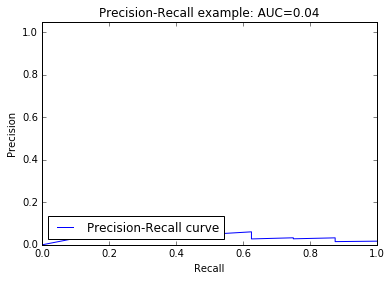

In [50]:
average_precision = metrics.average_precision_score(y_test, y_score)
precision, recall, threshold = metrics.precision_recall_curve(y_test, y_score)

plt.clf()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")

In [51]:
model = Sequential()

model.add(Embedding(num_words, 32, input_length=100))
model.add(Dropout(0.25))

model.add(GRU(32,activation='relu'))

model.add(Dense(256, W_regularizer=l2(0.01), activity_regularizer=activity_l2(0.01)))
model.add(Dropout(0.25))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

print "fitting model ...."
model.fit(X_train, y_train, batch_size=32, nb_epoch=20, verbose=0,validation_data=(X_test, y_test))#, sample_weight = sw,class_weight = {0:1., 1:25.})
score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1, show_accuracy=True)
print('Test score:', score[0])
print('Test accuracy:', score[1])

y_score = model.predict(X_test, batch_size=batch_size)
auc_score = metrics.roc_auc_score(y_test, y_score)
print("*** AUC for ROC = %0.3f\n" % auc_score)

y_pred = model.predict_classes(X_test)
y_test = np.array(y_test)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('\nAccuracy: {}'.format(accuracy))
print('Recall: {}'.format(recall))
print('Precision: {}'.format(precision))
print('F1: {}'.format(f1))

print("classification report:")
print(metrics.classification_report(y_test, y_pred,target_names=categories))

print("confusion matrix:")
print(metrics.confusion_matrix(y_test, y_pred))

fitting model ....
500/500 [==============================] - 0s     
('Test score:', 0.1810133366584778)
('Test accuracy:', 0.94599999618530273)
*** AUC for ROC = 0.665

500/500 [==============================] - 0s     

Accuracy: 0.946
Recall: 0.0
Precision: 0.0
F1: 0.0
classification report:
             precision    recall  f1-score   support

 Irrelevant       0.98      0.96      0.97       492
   Relevant       0.00      0.00      0.00         8

avg / total       0.97      0.95      0.96       500

confusion matrix:
[[473  19]
 [  8   0]]


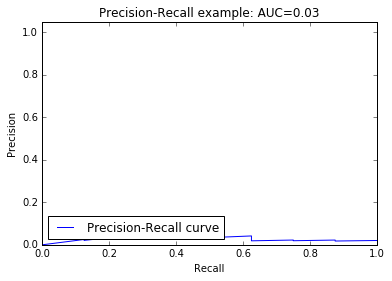

In [52]:
average_precision = metrics.average_precision_score(y_test, y_score)
precision, recall, threshold = metrics.precision_recall_curve(y_test, y_score)

plt.clf()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")

In [55]:
y_score = model.predict(X_hold, batch_size=batch_size)
auc_score = metrics.roc_auc_score(y_hold, y_score)
print("*** AUC for ROC = %0.3f\n" % auc_score)

y_pred = model.predict_classes(X_hold)
y_test = np.array(y_hold)
accuracy = accuracy_score(y_hold, y_pred)
recall = recall_score(y_hold, y_pred)
precision = precision_score(y_hold, y_pred)
f1 = f1_score(y_hold, y_pred)

print('\nAccuracy: {}'.format(accuracy))
print('Recall: {}'.format(recall))
print('Precision: {}'.format(precision))
print('F1: {}'.format(f1))

print("classification report:")
print(metrics.classification_report(y_hold, y_pred,target_names=categories))

print("confusion matrix:")
print(metrics.confusion_matrix(y_hold, y_pred))

*** AUC for ROC = 0.740

480/500 [===========================>..] - ETA: 0s
Accuracy: 0.958
Recall: 0.125
Precision: 0.0666666666667
F1: 0.0869565217391
classification report:
             precision    recall  f1-score   support

 Irrelevant       0.99      0.97      0.98       492
   Relevant       0.07      0.12      0.09         8

avg / total       0.97      0.96      0.96       500

confusion matrix:
[[478  14]
 [  7   1]]


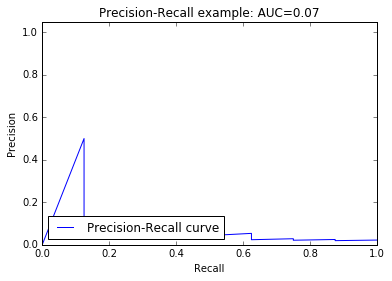

In [57]:
average_precision = metrics.average_precision_score(y_hold, y_score)
precision, recall, threshold = metrics.precision_recall_curve(y_hold, y_score)

plt.clf()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")